multivariate times series
regular times series
var model et non arima
verifier si stationnary
use referencing if not





In [32]:
#importing the libraries
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, time
from vacances_scolaires_france import SchoolHolidayDates
import sys
#from impyute.imputation.cs import mice
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
#pip install vacances-scolaires-france
#pip3 install impyute
#yconda install -c plotly plotly=4.0.0
# my fonctions
def conv(data):
    data["date"] = data.timestamp.apply(lambda x : x.split('T')[0])
    data["datetime_perso"] = data.timestamp.apply(lambda x : get_format_the_date(x))
    data['year']=data['datetime_perso'].dt.year
    data['month']=data['datetime_perso'].dt.month
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data['hours'] = data['timestamp'].dt.hour
    return data

## get season
def get_season(doy):
    spring = range(80, 172)
    summer = range(172, 264)
    fall = range(264, 355)
    if doy in spring:
        season = 'spring'
    elif doy in summer:
        season = 'summer'
    elif doy in fall:
        season = 'fall'
    else:
        season = 'winter'
    return season

## verifie si jour ferie
def easter_date(year):
    a = year // 100
    b = year % 100
    c = (3 * (a + 25)) // 4
    d = (3 * (a + 25)) % 4
    e = (8 * (a + 11)) // 25
    f = (5 * a + b) % 19
    g = (19 * f + c - e) % 30
    h = (f + 11 * g) // 319
    j = (60 * (5 - d) + b) // 4
    k = (60 * (5 - d) + b) % 4
    m = (2 * j - k - g + h) % 7
    n = (g - h + m + 114) // 31
    p = (g - h + m + 114) % 31
    day = p + 1
    month = n
    return datetime(year, month, day)

def is_ferie(the_date):
    year = the_date.year
    easter = easter_date(year)
    days = [
        datetime(year, 1, 1),  # Premier de l'an
        easter + timedelta(days=1),  # Lundi de Pâques
        datetime(year, 5, 1),  # Fête du Travail
        datetime(year, 5, 8),  # Victoire de 1945
        easter + timedelta(days=39),  # Ascension
        easter + timedelta(days=49),  # Pentecôte
        datetime(year, 7, 14),  # Fête Nationale
        datetime(year, 8, 15),  # Assomption
        datetime(year, 11, 1),  # Toussaint
        datetime(year, 11, 11),  # Armistice 1918
        datetime(year, 12, 25),  # Noël
    ]
    return the_date in days

def get_format_the_date(timestamp):
    do = datetime.strptime(timestamp, '%Y-%m-%dT%H:%M:%S.%f')
    d5 = do.replace(minute=0, hour=0, second=0, microsecond=0).isoformat(' ')
    the_date = datetime.strptime(d5, "%Y-%m-%d %H:%M:%S")
    return the_date

def business_day(timestamp):
    if not is_ferie(timestamp) and timestamp.isoweekday() not in [6, 7]:
        return True
    else:
        return False
    
  

In [33]:
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

In [34]:
#creating a function to encapsulate preprocessing, to mkae it easy to replicate on  submission data
# tester aussi avec dataInt et DataTeat separer dans une future version

def processing(dataInt):
    ## missing value
    df = dataInt.copy()
    df_num = df.drop(['timestamp','loc_1', 'loc_2', 'loc_secondary_1', 'loc_secondary_2', 'loc_secondary_3'], axis=1)
    df_NonNum = df.select_dtypes(include=[np.object])
    
    #df_mice = df_num[:50]
    
    
    #nan_rows = df_mice[df_mice.isnull().any(axis=1)]
    #index = list(nan_rows.index)
    #if index[0] == 0:
    #   imputed_training_mice = mice(df_mice.values)
    #    data_mice = pd.DataFrame(imputed_training_mice, columns = df_num.columns, index = list(df_mice[:50].index.values))
    #    #replace 50 lignes
    #    df_num[:50] = data_mice
        
    #    dClean = df_num.join(df_NonNum)
    #else:
    #    pass
    ## drop variable inutile
    d_tr = df.drop(['loc_1', 'loc_2', 'loc_secondary_1', 'loc_secondary_2', 'loc_secondary_3'], axis=1)
    ## create extra attribute
    conv(d_tr)
    d_tr['timestamp'] = pd.to_datetime(d_tr.timestamp, format = '%Y-%m-%dT%H:%M:%S.%f')
    ## create season and rangeInYear
    s = pd.to_datetime(pd.Series(d_tr['timestamp']))
    d_tr['rangeInYear'] = s.dt.strftime('%j').astype(int)
    #create jours working days
    d_tr['is_business_day'] = d_tr['datetime_perso'].apply(lambda e : int(business_day(e)))
    # Is it an holiday for zone A, B or C?
    d = SchoolHolidayDates()
    d_tr['is_holiday'] = d_tr['datetime_perso'].apply(lambda f : int(d.is_holiday(datetime.date(f))))
    d_tr['season'] = d_tr['rangeInYear'].apply(lambda d : get_season(d))
    dataInt1 = d_tr.drop(['rangeInYear', 'datetime_perso', 'date'], axis=1)
    return (dataInt1)    



In [35]:
#metric donner par l"ENS

In [36]:

def weighted_mean_absolute_error(dataframe_1, dataframe_2):
    """Weighted mean absolute error regression loss

        ----------
        y_true : array-like of shape = (n_samples,2)
        Ground truth (correct) target values.
        y_pred : array-like of shape = (n_samples,2)
        Estimated target values.

        """

    y_true = dataframe_1.values
    y_pred = dataframe_2.values
    c12 = np.array([1136987, 1364719])

    return 2 * metrics.mean_absolute_error(y_true*c12, y_pred*c12) / np.sum(c12)

--------------------------------------------------------------------------------------------------------------------

In [37]:
# creere un je
dataInt_raw = pd.read_csv('./data_set1/input_training_ssnsrY0.csv')
dataOut_raw = pd.read_csv('./data_set1/output_training_Uf11I9I.csv')
dataTest_raw = pd.read_csv('./data_set1/input_test_cdKcI0e.csv')
dataInt_raw = dataInt_raw.drop(['ID'], axis=1)
dataOut_raw = dataOut_raw.drop(['ID'], axis=1)

data = pd.concat([dataInt_raw, dataOut_raw[['consumption_1', 'consumption_2']]], axis=1)
data.head()
data.columns
#----------------------

Index(['timestamp', 'temp_1', 'temp_2', 'mean_national_temp', 'humidity_1',
       'humidity_2', 'loc_1', 'loc_2', 'loc_secondary_1', 'loc_secondary_2',
       'loc_secondary_3', 'consumption_secondary_1', 'consumption_secondary_2',
       'consumption_secondary_3', 'consumption_1', 'consumption_2'],
      dtype='object')

In [38]:
data.head(2)

timestamp  temp_1  temp_2  mean_national_temp  humidity_1  \
0  2016-11-01T00:00:00.0     8.3     NaN                11.1        95.0   
1  2016-11-01T01:00:00.0     8.0     NaN                11.1        98.0   

   humidity_2            loc_1            loc_2   loc_secondary_1  \
0         NaN  (50.633, 3.067)  (43.530, 5.447)  (44.838, -0.579)   
1         NaN  (50.633, 3.067)  (43.530, 5.447)  (44.838, -0.579)   

    loc_secondary_2  loc_secondary_3  consumption_secondary_1  \
0  (47.478, -0.563)  (48.867, 2.333)                      143   
1  (47.478, -0.563)  (48.867, 2.333)                      141   

   consumption_secondary_2  consumption_secondary_3  consumption_1  \
0                       74                      168            100   
1                       60                      162            101   

   consumption_2  
0             93  
1             94

In [39]:
dataNew = processing(data)

In [40]:
import plotly
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [41]:
groupBy_whole = dataNew.groupby('timestamp').mean()



trace1 = go.Scatter(
        x=groupBy_whole.temp_1.index, 
        y=groupBy_whole.temp_1, 
        mode = 'lines',
        name = 'temp_1',
        marker = dict(color = 'rgba(0, 191, 205, 0.4)'))
trace2 = go.Scatter(
        x=groupBy_whole.temp_2.index, 
        y=groupBy_whole.temp_2, 
        mode = 'lines',
        name = 'temp_2',
        marker = dict(color = 'rgba(1, 50, 2, 0.2)'))
trace3 = go.Scatter(
        x=groupBy_whole.mean_national_temp.index, 
        y=groupBy_whole.mean_national_temp, 
        mode = 'lines',
        name = 'mean_national_temp',
        marker = dict(color = 'rgba(0, 61, 80, 0.6)'))
trace4 = go.Scatter(
        x=groupBy_whole.humidity_1.index, 
        y=groupBy_whole.humidity_1, 
        name = 'humidity_1',
        line = dict(
            color = 'rgba(0, 191, 205, 0.6)',
            width = 2,
            dash = 'dot'))
trace5 = go.Scatter(
        x=groupBy_whole.humidity_2.index, 
        y=groupBy_whole.humidity_2, 
        name = 'humidity_2',
        line = dict(
            color = 'rgba(1, 50, 2, 0.4)',
            width = 2,
            dash = 'dot'))

data = [trace1, trace2, trace3, trace4, trace5]

# layout=dict(title="Time Series Plot for Mean Daily temperature", xaxis={'title':'Date'}, yaxis={'title':'Temp/Humidity'})
layout = dict(
    title="Time Series Plot for Mean Daily temperature",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=4,
                     label='4m',
                     step='month',
                     stepmode='backward'),
                dict(count=1,
                    label='YTD',
                    step='year',
                    stepmode='todate'),
                dict(count=1,
                    label='1y',
                    step='year',
                    stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    ),
    yaxis={'title':'Temp/Humidity'}
)
fig=dict(data=data,layout=layout)
iplot(fig)

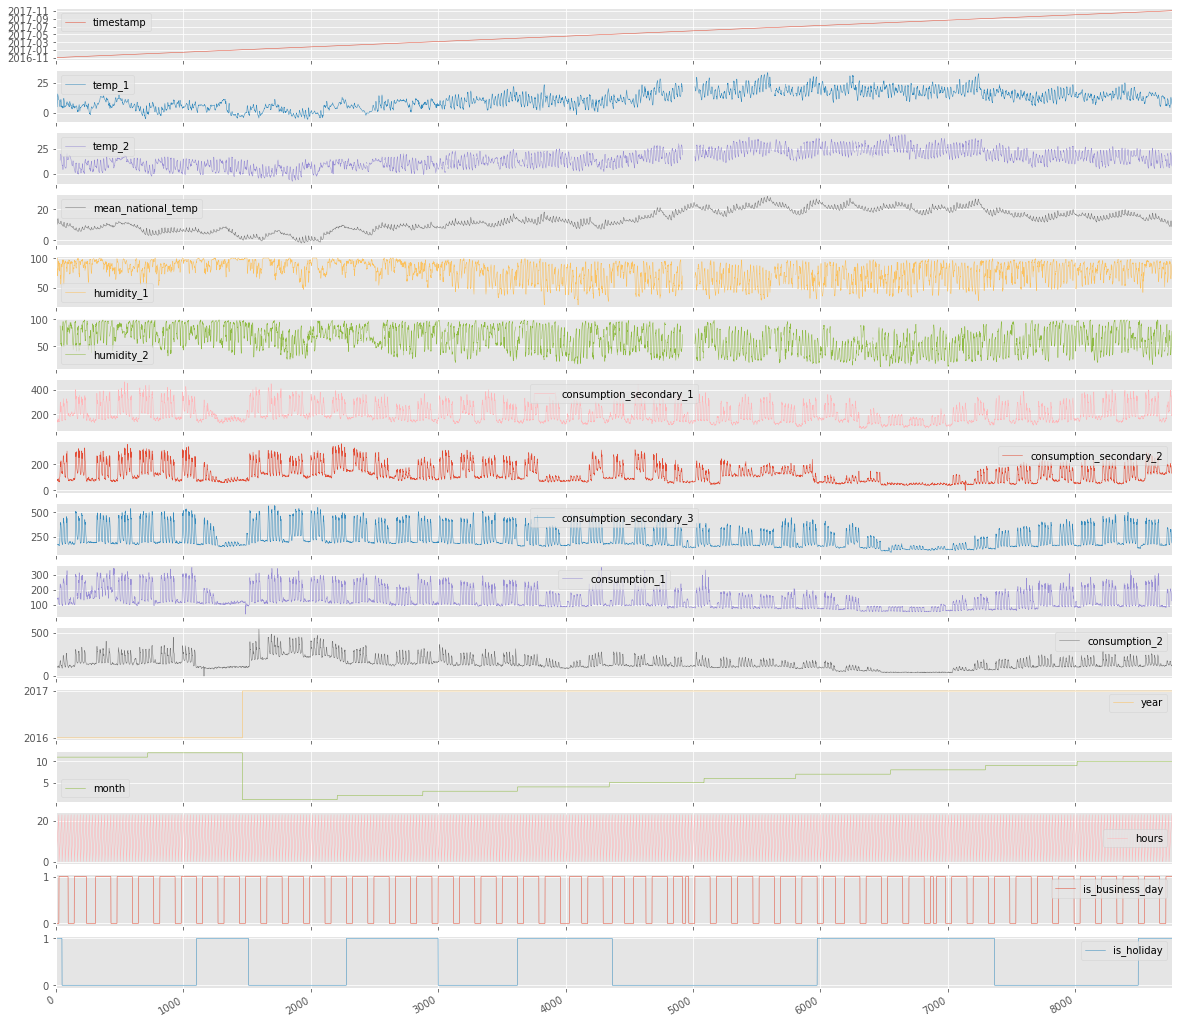

In [42]:
cols_plot = dataNew.columns
axes = dataNew[cols_plot].plot(alpha=1., linewidth=.5, figsize=(20, 20), subplots=True, sharex=True)

In [43]:
consum_varaiables = ['consumption_secondary_1', 'consumption_secondary_2', 'consumption_secondary_3' ]
dataNew['consum_mean'] = dataNew[consum_varaiables].mean(axis=1)
dataNew = dataNew.drop(['consumption_secondary_1', 'consumption_secondary_2', 'consumption_secondary_3'], axis=1)


In [44]:
categorical_features = ['month', 'hours', 'season', 'is_holiday','is_business_day']
for var in categorical_features:
    dataNew[var] = dataNew[var].astype('category')

In [45]:
from pandas.api.types import CategoricalDtype
for column in categorical_features:
    dataNew[column] = dataNew[column].astype(CategoricalDtype(categories = dataNew[column].unique(), ordered=True))
    

In [46]:
dataNew = pd.get_dummies(dataNew, drop_first=True)
dataNew = dataNew[dataNew.columns]
list(dataNew.columns)

['timestamp',
 'temp_1',
 'temp_2',
 'mean_national_temp',
 'humidity_1',
 'humidity_2',
 'consumption_1',
 'consumption_2',
 'year',
 'consum_mean',
 'month_12',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'hours_1',
 'hours_2',
 'hours_3',
 'hours_4',
 'hours_5',
 'hours_6',
 'hours_7',
 'hours_8',
 'hours_9',
 'hours_10',
 'hours_11',
 'hours_12',
 'hours_13',
 'hours_14',
 'hours_15',
 'hours_16',
 'hours_17',
 'hours_18',
 'hours_19',
 'hours_20',
 'hours_21',
 'hours_22',
 'hours_23',
 'is_business_day_1',
 'is_holiday_0',
 'season_winter',
 'season_spring',
 'season_summer']

In [47]:
#dataNew = dataNew.drop(['ID'], axis=1)

In [48]:
dataNew.head(2)

timestamp  temp_1  temp_2  mean_national_temp  humidity_1  \
0 2016-11-01 00:00:00     8.3     NaN                11.1        95.0   
1 2016-11-01 01:00:00     8.0     NaN                11.1        98.0   

   humidity_2  consumption_1  consumption_2  year  consum_mean  ...  hours_19  \
0         NaN            100             93  2016   128.333333  ...         0   
1         NaN            101             94  2016   121.000000  ...         0   

   hours_20  hours_21  hours_22  hours_23  is_business_day_1  is_holiday_0  \
0         0         0         0         0                  0             0   
1         0         0         0         0                  0             0   

   season_winter  season_spring  season_summer  
0              0              0              0  
1              0              0              0  

[2 rows x 49 columns]

In [49]:
dataNew['timestamp'] = pd.to_datetime(dataNew['timestamp'])
dataNew.set_index('timestamp', inplace=True)
dataNew.head(2)

temp_1  temp_2  mean_national_temp  humidity_1  \
timestamp                                                             
2016-11-01 00:00:00     8.3     NaN                11.1        95.0   
2016-11-01 01:00:00     8.0     NaN                11.1        98.0   

                     humidity_2  consumption_1  consumption_2  year  \
timestamp                                                             
2016-11-01 00:00:00         NaN            100             93  2016   
2016-11-01 01:00:00         NaN            101             94  2016   

                     consum_mean  month_12  ...  hours_19  hours_20  hours_21  \
timestamp                                   ...                                 
2016-11-01 00:00:00   128.333333         0  ...         0         0         0   
2016-11-01 01:00:00   121.000000         0  ...         0         0         0   

                     hours_22  hours_23  is_business_day_1  is_holiday_0  \
timestamp                                                                  
2016-11-01 00:00:00         0         0                  0             0   
2016-11-01 01:00:00         0         0                  0             0   

                     season_winter  season_spring  season_summer  
timestamp                                                         
2016-11-01 00:00:00              0              0              0  
2016-11-01 01:00:00              0              0              0  

[2 rows x 48 columns]

In [50]:
dataNew.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2016-11-01 00:00:00 to 2017-10-31 23:00:00
Data columns (total 48 columns):
temp_1                8589 non-null float64
temp_2                8429 non-null float64
mean_national_temp    8760 non-null float64
humidity_1            8589 non-null float64
humidity_2            8428 non-null float64
consumption_1         8760 non-null int64
consumption_2         8760 non-null int64
year                  8760 non-null int64
consum_mean           8760 non-null float64
month_12              8760 non-null uint8
month_1               8760 non-null uint8
month_2               8760 non-null uint8
month_3               8760 non-null uint8
month_4               8760 non-null uint8
month_5               8760 non-null uint8
month_6               8760 non-null uint8
month_7               8760 non-null uint8
month_8               8760 non-null uint8
month_9               8760 non-null uint8
month_10              8760 non-null uint8
hours

In [51]:
dataNew.assign(missing=np.nan)

temp_1  temp_2  mean_national_temp  humidity_1  \
timestamp                                                             
2016-11-01 00:00:00     8.3     NaN                11.1        95.0   
2016-11-01 01:00:00     8.0     NaN                11.1        98.0   
2016-11-01 02:00:00     6.8     NaN                11.0        97.0   
2016-11-01 03:00:00     7.5     NaN                10.9        99.0   
2016-11-01 04:00:00     6.1     NaN                10.8        98.0   
...                     ...     ...                 ...         ...   
2017-10-31 19:00:00    11.1    13.6                10.1        78.0   
2017-10-31 20:00:00    10.3    11.8                 9.6        81.0   
2017-10-31 21:00:00     9.0    10.0                 9.2        86.0   
2017-10-31 22:00:00     8.0     9.0                 8.9        88.0   
2017-10-31 23:00:00     7.0     7.9                 8.8        90.0   

                     humidity_2  consumption_1  consumption_2  year  \
timestamp                                                             
2016-11-01 00:00:00         NaN            100             93  2016   
2016-11-01 01:00:00         NaN            101             94  2016   
2016-11-01 02:00:00         NaN            100             96  2016   
2016-11-01 03:00:00         NaN            101             95  2016   
2016-11-01 04:00:00         NaN            100            100  2016   
...                         ...            ...            ...   ...   
2017-10-31 19:00:00        53.0            144            121  2017   
2017-10-31 20:00:00        62.0            129            119  2017   
2017-10-31 21:00:00        70.0            128            122  2017   
2017-10-31 22:00:00        73.0            126            116  2017   
2017-10-31 23:00:00        78.0            126            117  2017   

                     consum_mean  month_12  ...  hours_20  hours_21  hours_22  \
timestamp                                   ...                                 
2016-11-01 00:00:00   128.333333         0  ...         0         0         0   
2016-11-01 01:00:00   121.000000         0  ...         0         0         0   
2016-11-01 02:00:00   122.000000         0  ...         0         0         0   
2016-11-01 03:00:00   120.333333         0  ...         0         0         0   
2016-11-01 04:00:00   126.000000         0  ...         0         0         0   
...                          ...       ...  ...       ...       ...       ...   
2017-10-31 19:00:00   211.666667         0  ...         0         0         0   
2017-10-31 20:00:00   187.666667         0  ...         1         0         0   
2017-10-31 21:00:00   177.666667         0  ...         0         1         0   
2017-10-31 22:00:00   172.666667         0  ...         0         0         1   
2017-10-31 23:00:00   171.666667         0  ...         0         0         0   

                     hours_23  is_business_day_1  is_holiday_0  season_winter  \
timestamp                                                                       
2016-11-01 00:00:00         0                  0             0              0   
2016-11-01 01:00:00         0                  0             0              0   
2016-11-01 02:00:00         0                  0             0              0   
2016-11-01 03:00:00         0                  0             0              0   
2016-11-01 04:00:00         0                  0             0              0   
...                       ...                ...           ...            ...   
2017-10-31 19:00:00         0                  1             0              0   
2017-10-31 20:00:00         0                  1             0              0   
2017-10-31 21:00:00         0                  1             0              0   
2017-10-31 22:00:00         0                  1             0              0   
2017-10-31 23:00:00         1                  1             0              0   

                     season_spring  season_summer  missing  
time

In [188]:
ax = dataNew.loc['2016-11-01':'2016-11-30', 'temp_2'].plot(linestyle='-') # avec handling value

In [205]:
ax = dataNew.loc['2016-11-01':'2016-11-30', 'temp_2'].plot(linestyle='-') # avec MICE

In [249]:
#dataNew = dataNew.assign(InterpolateTime=dataNew.temp_2.interpolate(method='linear'))
#dataNew['temp_2'].interpolate(method='time',limit_direction='both',limit=100,  inplace=True)

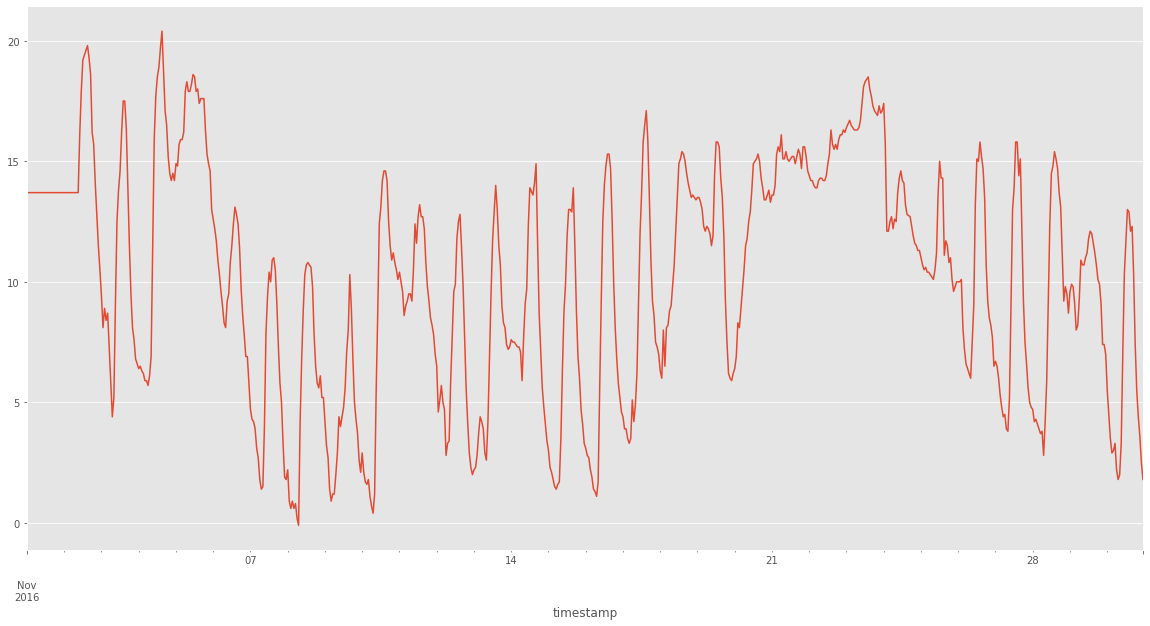

In [251]:
ax = dataNew.loc['2016-11-01':'2016-11-30', 'temp_2'].plot(linestyle='-') # avec interpolation

In [52]:
numerical_features = [f for f in dataNew.columns if dataNew[f].dtype == float]
scaler =  StandardScaler()
scaler.fit(dataNew[numerical_features].values)
dataNew[numerical_features] = scaler.transform(dataNew[numerical_features].values)




In [53]:
dataNew.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2016-11-01 00:00:00 to 2017-10-31 23:00:00
Data columns (total 48 columns):
temp_1                8589 non-null float64
temp_2                8429 non-null float64
mean_national_temp    8760 non-null float64
humidity_1            8589 non-null float64
humidity_2            8428 non-null float64
consumption_1         8760 non-null int64
consumption_2         8760 non-null int64
year                  8760 non-null int64
consum_mean           8760 non-null float64
month_12              8760 non-null uint8
month_1               8760 non-null uint8
month_2               8760 non-null uint8
month_3               8760 non-null uint8
month_4               8760 non-null uint8
month_5               8760 non-null uint8
month_6               8760 non-null uint8
month_7               8760 non-null uint8
month_8               8760 non-null uint8
month_9               8760 non-null uint8
month_10              8760 non-null uint8
hours

In [54]:
from fancyimpute import KNN

In [55]:
dataNew.head()

temp_1  temp_2  mean_national_temp  humidity_1  \
timestamp                                                               
2016-11-01 00:00:00 -0.440140     NaN           -0.320320    1.060785   
2016-11-01 01:00:00 -0.482696     NaN           -0.320320    1.241104   
2016-11-01 02:00:00 -0.652921     NaN           -0.335766    1.180998   
2016-11-01 03:00:00 -0.553623     NaN           -0.351211    1.301210   
2016-11-01 04:00:00 -0.752219     NaN           -0.366657    1.241104   

                     humidity_2  consumption_1  consumption_2  year  \
timestamp                                                             
2016-11-01 00:00:00         NaN            100             93  2016   
2016-11-01 01:00:00         NaN            101             94  2016   
2016-11-01 02:00:00         NaN            100             96  2016   
2016-11-01 03:00:00         NaN            101             95  2016   
2016-11-01 04:00:00         NaN            100            100  2016   

                     consum_mean  month_12  ...  hours_19  hours_20  hours_21  \
timestamp                                   ...                                 
2016-11-01 00:00:00    -0.794285         0  ...         0         0         0   
2016-11-01 01:00:00    -0.892797         0  ...         0         0         0   
2016-11-01 02:00:00    -0.879364         0  ...         0         0         0   
2016-11-01 03:00:00    -0.901753         0  ...         0         0         0   
2016-11-01 04:00:00    -0.825630         0  ...         0         0         0   

                     hours_22  hours_23  is_business_day_1  is_holiday_0  \
timestamp                                                                  
2016-11-01 00:00:00         0         0                  0             0   
2016-11-01 01:00:00         0         0                  0             0   
2016-11-01 02:00:00         0         0                  0             0   
2016-11-01 03:00:00         0         0                  0             0   
2016-11-01 04:00:00         0         0                  0             0   

                     season_winter  season_spring  season_summer  
timestamp                                                         
2016-11-01 00:00:00              0              0              0  
2016-11-01 01:00:00              0              0              0  
2016-11-01 02:00:00              0              0              0  
2016-11-01 03:00:00              0              0              0  
2016-11-01 04:00:00              0              0              0  

[5 rows x 48 columns]

In [56]:
df_numeric = dataNew.select_dtypes(include=[np.float])

df_dummies = dataNew.drop(['temp_1', 'temp_2', 'mean_national_temp', 'humidity_1', 'humidity_2'], axis=1)
df_numeric.head(5)

temp_1  temp_2  mean_national_temp  humidity_1  \
timestamp                                                               
2016-11-01 00:00:00 -0.440140     NaN           -0.320320    1.060785   
2016-11-01 01:00:00 -0.482696     NaN           -0.320320    1.241104   
2016-11-01 02:00:00 -0.652921     NaN           -0.335766    1.180998   
2016-11-01 03:00:00 -0.553623     NaN           -0.351211    1.301210   
2016-11-01 04:00:00 -0.752219     NaN           -0.366657    1.241104   

                     humidity_2  consum_mean  
timestamp                                     
2016-11-01 00:00:00         NaN    -0.794285  
2016-11-01 01:00:00         NaN    -0.892797  
2016-11-01 02:00:00         NaN    -0.879364  
2016-11-01 03:00:00         NaN    -0.901753  
2016-11-01 04:00:00         NaN    -0.825630

In [57]:
df_dummies.head()

consumption_1  consumption_2  year  consum_mean  \
timestamp                                                              
2016-11-01 00:00:00            100             93  2016    -0.794285   
2016-11-01 01:00:00            101             94  2016    -0.892797   
2016-11-01 02:00:00            100             96  2016    -0.879364   
2016-11-01 03:00:00            101             95  2016    -0.901753   
2016-11-01 04:00:00            100            100  2016    -0.825630   

                     month_12  month_1  month_2  month_3  month_4  month_5  \
timestamp                                                                    
2016-11-01 00:00:00         0        0        0        0        0        0   
2016-11-01 01:00:00         0        0        0        0        0        0   
2016-11-01 02:00:00         0        0        0        0        0        0   
2016-11-01 03:00:00         0        0        0        0        0        0   
2016-11-01 04:00:00         0        0        0        0        0        0   

                     ...  hours_19  hours_20  hours_21  hours_22  hours_23  \
timestamp            ...                                                     
2016-11-01 00:00:00  ...         0         0         0         0         0   
2016-11-01 01:00:00  ...         0         0         0         0         0   
2016-11-01 02:00:00  ...         0         0         0         0         0   
2016-11-01 03:00:00  ...         0         0         0         0         0   
2016-11-01 04:00:00  ...         0         0         0         0         0   

                     is_business_day_1  is_holiday_0  season_winter  \
timestamp                                                             
2016-11-01 00:00:00                  0             0              0   
2016-11-01 01:00:00                  0             0              0   
2016-11-01 02:00:00                  0             0              0   
2016-11-01 03:00:00                  0             0              0   
2016-11-01 04:00:00                  0             0              0   

                     season_spring  season_summer  
timestamp                                          
2016-11-01 00:00:00              0              0  
2016-11-01 01:00:00              0              0  
2016-11-01 02:00:00              0              0  
2016-11-01 03:00:00              0              0  
2016-11-01 04:00:00              0              0  

[5 rows x 43 columns]

In [58]:
df_numeric.shape

(8760, 6)

In [ ]:


df_filled = pd.DataFrame(KNN(3).fit_transform(df_numeric))



In [29]:
df_filled.columns = df_numeric.columns
df_filled.index = df_numeric.index

In [30]:
df_filled.head(2)

temp_1    temp_2  mean_national_temp  humidity_1  \
timestamp                                                                 
2016-11-01 00:00:00 -0.440140 -0.987516            -0.32032    1.060785   
2016-11-01 01:00:00 -0.482696 -0.717975            -0.32032    1.241104   

                     humidity_2  consum_mean  
timestamp                                     
2016-11-01 00:00:00    1.481382    -0.794285  
2016-11-01 01:00:00    1.115429    -0.892797

In [31]:
ax = df_filled.loc['2016-11-01':'2016-11-30', 'temp_2'].plot(linestyle='-')

In [ ]:
Data_end = pd.DataFrame(imputed_training_mice, columns = df_num.columns, index = list(df.index.values))